In [46]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import os
from IPython.display import display
import numpy as np
import seaborn as sns
import re

In [47]:
emissions = pd.read_csv('merged_processed_emissions_modified.csv')
emissions['Country'] = emissions['Country'].str.replace(r'(?<=[a-z])(?=[A-Z])', ' ', regex=True)
emissions = emissions[emissions['Country'] != 'Tuvalu']
gdp = pd.read_excel('GDP2.xls')


In [48]:
gdp.rename(columns={'Country Name': 'Country'}, inplace=True)

merged_data = emissions.merge(gdp, on='Country', how='left', suffixes=('', '_gdp'))

for col in gdp.columns:
    if col != 'Country':  
        merged_data.rename(columns={col: f"{col}_gdp"}, inplace=True)


merged_data.to_csv('merged_emissions_with_gdp.csv', index=False)
merged_data = pd.read_csv('merged_emissions_with_gdp.csv')


In [49]:
for year in range(2000, 2023):
    merged_data[str(year)] = pd.to_numeric(merged_data[str(year)], errors='coerce')
    merged_data[f'{year}_gdp'] = pd.to_numeric(merged_data[f'{year}_gdp'], errors='coerce')

europe = ['European Union', 'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'Former Czechoslovakia',
          'France', 'Germany', 'Germany,East', 'Germany,West', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta',
          'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']
asia = ['Afghanistan', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Bhutan', 'Brunei', 'Burma', 'Cambodia', 'China', 'Georgia', 'India', 'Indonesia',
        'Iran', 'Iraq', 'Israel', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Lebanon', 'Malaysia', 'Maldives', 'Mongolia', 'Nepal',
        'North Korea', 'Oman', 'Pakistan', 'Palestinian Territories', 'Philippines', 'Qatar', 'Russia', 'Saudi Arabia', 'Singapore', 'South Korea', 'SriLanka',
        'Syria', 'Taiwan', 'Tajikistan', 'Thailand', 'Timor-Leste', 'Turkmenistan', 'United Arab Emirates', 'Uzbekistan', 'Vietnam', 'Yemen']
africa = ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'CapeVerde', 'Central African Republic', 'Chad', 'Comoros',
          'Congo-Brazzaville', 'Congo-Kinshasa', 'Djibouti', 'Egypt', 'EquatorialGuinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia,The', 'Ghana',
          'Guinea', 'Guinea-Bissau', 'IvoryCoast', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius',
          'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Senegal', 'Seychelles', 'SierraLeone', 'Somalia', 'SouthAfrica', 'SouthSudan',
          'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe']
north_america = ['Antigua and Barbuda', 'Bahamas', 'Barbados', 'Belize', 'Canada', 'CostaRica', 'Cuba', 'Dominica', 'DominicanRepublic', 'ElSalvador', 'Grenada',
                 'Guatemala', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua', 'Panama', 'SaintKittsandNevis', 'SaintLucia', 'Saint Vincent/Grenadines', 'Trinidad and Tobago',
                 'United States']
south_america = ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Guyana', 'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela']
oceania = ['Australia', 'Fiji', 'Kiribati', 'Marshall Islands', 'Micronesia', 'Nauru', 'New Zealand', 'Palau', 'Papua New Guinea', 'Samoa', 'Solomon Islands', 'Tonga', 'Tuvalu', 'Vanuatu']

excluded_groups = ['OPEC-South America', 'OPEC-Africa', 'OPEC', 'OECD-North America', 'OECD-Europe', 'OECD-Asia And Oceania', 'OECD']

def assign_continent(country):
    if country in europe:
        return 'Europe'
    elif country in asia:
        return 'Asia'
    elif country in africa:
        return 'Africa'
    elif country in north_america:
        return 'North America'
    elif country in south_america:
        return 'South America'
    elif country in oceania:
        return 'Oceania'
    else:
        return None 

merged_data = merged_data[~merged_data['Country'].isin(excluded_groups)].copy()  # Create a copy here

merged_data.loc[:, 'Continent'] = merged_data['Country'].apply(assign_continent)  # No warning now

In [50]:
year_columns = [col for col in merged_data.columns if col.isdigit() and len(col) == 4]

columns_to_drop = [col for col in year_columns if int(col) < 2000]

merged_2 = merged_data.drop(columns=columns_to_drop)

rows_with_nan = merged_2[merged_2.isna().sum(axis=1) > 10]

merged_2 = merged_2[merged_2.isna().sum(axis=1) <= 10]


In [51]:
year_columns = [col for col in merged_2.columns if col.isdigit() and len(col) == 4]
gdp_columns = [f"{col}_gdp" for col in year_columns]

melted_df = pd.melt(
    merged_2,
    id_vars=['Country', 'Type of Emission', 'Continent'], 
    value_vars=year_columns + gdp_columns,  
    var_name='Variable',  
    value_name='Value'   
)

melted_df['Year'] = melted_df['Variable'].where(melted_df['Variable'].isin(year_columns)).dropna()
melted_df['Year_gdp'] = melted_df['Variable'].where(melted_df['Variable'].isin(gdp_columns)).dropna()

melted_df = melted_df.drop(columns=['Variable'])

final_melted_df = melted_df.drop_duplicates().copy()

continent_mapping = {
    'Bermuda': 'North America',
    'Dominican Republic': 'North America',
    'El Salvador': 'North America',
    'Equatorial Guinea': 'Africa',
    'Haiti': 'North America',
    'Sierra Leone': 'Africa',
    'South Africa': 'Africa',
    'Sri Lanka': 'Asia',
    'Costa Rica': 'North America',
    'Iceland': 'Europe',
    'Norway': 'Europe',
    'Puerto Rico': 'North America',
    'Switzerland': 'Europe',
    'Turkiye': 'Asia',
    'United Kingdom': 'Europe'
}

final_melted_df['Continent'] = final_melted_df.apply(
    lambda row: continent_mapping.get(row['Country'], row['Continent']) if pd.isna(row['Continent']) else row['Continent'], 
    axis=1
)


In [52]:
final_melted_df_co2 = final_melted_df[final_melted_df["Type of Emission"].str.strip() == "CO2 emissions (MMtonnes CO2)"].copy()

if final_melted_df_co2.empty:
    print("No data found for 'CO2 emissions (MMtonnes CO2)'. Please check the filtering condition.")
else:
    final_melted_df_co2.loc[:, 'Emissions'] = final_melted_df_co2.apply(
        lambda row: row['Value'] if pd.isnull(row['Year_gdp']) else None,
        axis=1
    )

    final_melted_df_co2.loc[:, 'GDP'] = final_melted_df_co2.apply(
        lambda row: row['Value'] if pd.isnull(row['Year']) else None,
        axis=1
    )

    final_melted_df_co2.drop(columns=['Value'], inplace=True)
    final_melted_df_cleaned = final_melted_df_co2.drop_duplicates()


In [53]:
final_melted_df_cleaned = final_melted_df_cleaned.copy()
final_melted_df_cleaned['Year_gdp_cleaned'] = final_melted_df_cleaned['Year_gdp'].str.extract(r'(\d{4})')[0]

In [54]:
gdp_mapping = final_melted_df_cleaned[final_melted_df_cleaned['Year_gdp_cleaned'].notna()][['Year_gdp_cleaned', 'Country', 'GDP']].set_index(['Year_gdp_cleaned', 'Country'])

for index, row in final_melted_df_cleaned[final_melted_df_cleaned['Year'].notna()].iterrows():
    key = (row['Year'], row['Country'])
    
    if key in gdp_mapping.index:
        final_melted_df_cleaned.at[index, 'GDP'] = gdp_mapping.at[key, 'GDP']

final_melted_df_cleaned = final_melted_df_cleaned.drop(columns=['Year_gdp', 'Year_gdp_cleaned'], errors='ignore')

final_melted_df_cleaned = final_melted_df_cleaned.dropna(subset=['Emissions'])

final_melted_df_cleaned

,Country,Type of Emission,Continent,Year,Emissions,GDP
0,European Union,CO2 emissions (MMtonnes CO2),Europe,2000,3575.377838,7.276390e+12
4,Austria,CO2 emissions (MMtonnes CO2),Europe,2000,60.998925,1.972900e+11
8,Belgium,CO2 emissions (MMtonnes CO2),Europe,2000,139.251736,2.367920e+11
12,Denmark,CO2 emissions (MMtonnes CO2),Europe,2000,53.582431,1.641590e+11
16,Finland,CO2 emissions (MMtonnes CO2),Europe,2000,51.841973,1.260200e+11
...,...,...,...,...,...,...
24624,Puerto Rico,CO2 emissions (MMtonnes CO2),North America,2022,17.259673,1.135670e+11
24680,Switzerland,CO2 emissions (MMtonnes CO2),Europe,2022,33.608990,8.184270e+11
24700,Turkiye,CO2 emissions (MMtonnes CO2),Asia,2022,391.591741,9.071180e+11
24708,United Kingdom,CO2 emissions (MMtonnes CO2),Europe,2022,353.406611,3.088840e+12


In [55]:
cpi_data = {
    'Year': [
        2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
        2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
        2020, 2021, 2022
    ],
    'CPI': [
        172.2, 177.1, 179.9, 184.0, 188.9, 195.3, 201.6, 207.3, 215.3, 214.5,
        218.1, 224.9, 229.6, 232.9, 236.7, 237.0, 240.0, 245.1, 251.1, 255.7,
        258.8, 271.0, 292.7
    ]
}

cpi_df = pd.DataFrame(cpi_data)

base_cpi = 100.0  

cpi_df['Scaling Factor'] = cpi_df['CPI'] / base_cpi

final_melted_df_cleaned['Year'] = pd.to_numeric(final_melted_df_cleaned['Year'], errors='coerce')
final_melted_df_cleaned = final_melted_df_cleaned.dropna(subset=['Year'])

filtered_df = final_melted_df_cleaned[(final_melted_df_cleaned['Year'] >= 2000) & 
                                      (final_melted_df_cleaned['Year'] <= 2022)]

updated_df = filtered_df.merge(cpi_df[['Year', 'Scaling Factor']], on='Year', how='left')

updated_df['Adjusted GDP'] = updated_df['GDP'] * updated_df['Scaling Factor']


In [56]:
updated_df['Year'] = pd.to_numeric(updated_df['Year'], errors='coerce')
updated_df['Adjusted GDP'] = pd.to_numeric(updated_df['Adjusted GDP'], errors='coerce')

updated_df = updated_df.dropna(subset=['Year', 'Adjusted GDP'])
gdp_data = updated_df[updated_df['Year'].between(2000, 2022)]
gdp_growth = gdp_data.groupby('Country')['Adjusted GDP'].apply(lambda x: x.pct_change() * 100).reset_index()
gdp_growth.rename(columns={'Adjusted GDP': 'GDP Growth'}, inplace=True)

avg_gdp_growth = gdp_growth.groupby('Country')['GDP Growth'].mean().reset_index()
avg_gdp_growth.rename(columns={'GDP Growth': 'Avg GDP Growth 2000-2022'}, inplace=True)

gdp_2022 = gdp_data[gdp_data['Year'] == 2022].groupby('Country')['Adjusted GDP'].last().reset_index()
top_10_percent_gdp = gdp_2022['Adjusted GDP'].quantile(0.9)
bottom_11_percent_gdp = gdp_2022['Adjusted GDP'].quantile(0.11)

gdp_growth = gdp_growth.merge(avg_gdp_growth, on='Country', how='left')


def classify_country(row):
    all_years_gdp = gdp_data[gdp_data['Country'] == row['Country']].groupby('Year')['Adjusted GDP'].max()
    if row['Avg GDP Growth 2000-2022'] < 10 and all_years_gdp.max() >= top_10_percent_gdp:
        return 'Developed countries'
    
    elif row['Avg GDP Growth 2000-2022'] > 10:
        return 'Newly industrialized countries #2'
    
    all_years_gdp_bottom = gdp_data[gdp_data['Country'] == row['Country']].groupby('Year')['Adjusted GDP'].max()
    if row['Avg GDP Growth 2000-2022'] < 10 and all_years_gdp_bottom.max() <= bottom_11_percent_gdp:
        return 'Low-income countries'
    
    return 'Other'

gdp_growth['Country Classification'] = gdp_growth.apply(classify_country, axis=1)
gdp_growth[['Country', 'Country Classification']].drop_duplicates()

,Country,Country Classification
0,Algeria,Newly industrialized countries #2
23,Australia,Newly industrialized countries #2
46,Austria,Other
69,Bahrain,Newly industrialized countries #2
92,Bangladesh,Newly industrialized countries #2
...,...,...
2438,United Kingdom,Developed countries
2461,United States,Developed countries
2484,Uruguay,Other
2507,Zambia,Newly industrialized countries #2


In [57]:
newly_industrialized_countries_list = [
    'Guyana', 'Equatorial Guinea', 'Ghana', 'Ethiopia', 'China',
    'Maldives', 'Chad', 'Iraq'
]

gdp_growth.loc[gdp_growth['Country'].isin(newly_industrialized_countries_list), 'Country Classification'] = 'Newly industrialized countries'

gdp_growth.loc[gdp_growth['Country'] == 'Mexico', 'Country Classification'] = 'Other'

unique_classifications = gdp_growth['Country Classification'].unique()
gdp_growth.groupby('Country Classification')['Country'].unique().reset_index()

,Country Classification,Country
0,Developed countries,"[Canada, European Union, France, Germany, Ital..."
1,Low-income countries,"[Belize, Burundi, Central African Republic, Es..."
2,Newly industrialized countries,"[Chad, China, Equatorial Guinea, Ethiopia, Gha..."
3,Newly industrialized countries #2,"[Algeria, Australia, Bahrain, Bangladesh, Beni..."
4,Other,"[Austria, Barbados, Belgium, Bermuda, Botswana..."


In [58]:
unique_countries_by_category = gdp_growth.groupby('Country Classification')['Country'].unique().reset_index()

for index, row in unique_countries_by_category.iterrows():
    print(f"Category: {row['Country Classification']}")
    print(f"Countries: {', '.join(row['Country'])}\n")

Category: Developed countries
Countries: Canada, European Union, France, Germany, Italy, Japan, United Kingdom, United States

Category: Low-income countries
Countries: Belize, Burundi, Central African Republic, Eswatini, Kiribati, Lesotho, Samoa, Seychelles

Category: Newly industrialized countries
Countries: Chad, China, Equatorial Guinea, Ethiopia, Ghana, Guyana, Iraq, Maldives

Category: Newly industrialized countries #2
Countries: Algeria, Australia, Bahrain, Bangladesh, Benin, Bolivia, Burkina Faso, Costa Rica, Dominican Republic, Ecuador, Gabon, Guatemala, Guinea, Guinea-Bissau, India, Indonesia, Ireland, Jordan, Kenya, Kuwait, Liberia, Malaysia, Mali, Malta, Mauritania, Nauru, Nepal, New Zealand, Niger, Nigeria, Oman, Panama, Papua New Guinea, Paraguay, Philippines, Rwanda, Saudi Arabia, Senegal, Sierra Leone, Singapore, Somalia, Sri Lanka, Sudan, Suriname, Tanzania, Uganda, Zambia, Zimbabwe

Category: Other
Countries: Austria, Barbados, Belgium, Bermuda, Botswana, Cameroon, Ch

In [59]:
developed_countries = ['Canada', 'European Union', 'France', 'Germany', 'Italy', 'Japan', 'United Kingdom', 'United States']
low_income_countries = ['Belize', 'Burundi', 'Central African Republic', 'Eswatini','Kiribati', 'Lesotho', 'Samoa', 'Seychelles']
newly_industrialized_countries = ['Chad', 'China', 'Equatorial Guinea', 'Ethiopia', 'Ghana', 'Guyana', 'Iraq', 'Maldives']

selected_countries = developed_countries + low_income_countries + newly_industrialized_countries

filtered_df = updated_df[updated_df['Country'].isin(selected_countries)]
groups_df = pd.merge(filtered_df, gdp_growth[['Country', 'Country Classification', 'Avg GDP Growth 2000-2022']], on='Country', how='left')

In [60]:
fig = px.scatter(
    groups_df[groups_df["Country Classification"].isin(["Newly industrialized countries", "Developed countries", "Low-income countries"])],
    x="Adjusted GDP", 
    y="Emissions", 
    log_x=True, 
    log_y=True, 
    symbol="Country",
    color="Year",  
    facet_col="Country Classification",  
    facet_col_wrap=3,  # Adjust wrap to match the number of subplots
    height=500  # Reduce height since all subplots are in one row
)

# Update layout to apply axis titles and add spacing between title and legend
fig.update_layout(
    title="CO2 Emissions vs. Adjusted GDP for Different Country Classifications",
    title_x=0.5,  # Centers the title
    title_y=1.0,  # Adjust the vertical position of the title
    legend=dict(
        orientation="h", 
        yanchor="bottom", 
        y=1.1,  # Moves the legend below the plot
        xanchor="right",  
        x=1  
    ),
    yaxis_title="CO2 Emissions (MMtonnes CO2)", 
    xaxis_title="GDP (USD)",  # This applies to all facets
    height=700 
)

# Apply the x-axis title across all subplots
fig.update_xaxes(title_text="GDP (USD)")  # Set the x-axis title for all subplots

fig.show()

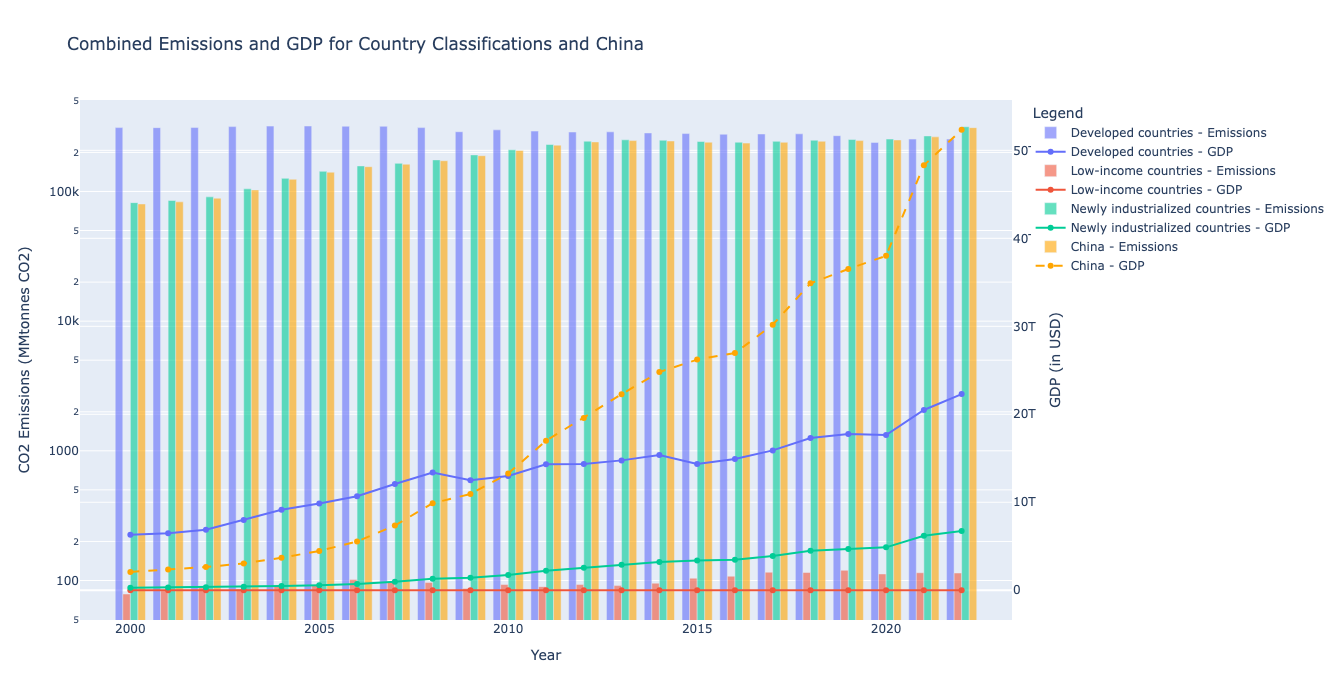

In [61]:
grouped_data = groups_df.groupby(['Country Classification', 'Year']).agg(
    combined_emissions=('Emissions', 'sum'),
    avg_adjusted_gdp=('Adjusted GDP', 'mean')
).reset_index()

china_data = groups_df[groups_df['Country'] == 'China'].groupby(['Year']).agg(
    combined_emissions=('Emissions', 'sum'),
    avg_adjusted_gdp=('Adjusted GDP', 'mean')
).reset_index()

fig = go.Figure()

for classification in grouped_data['Country Classification'].unique():
    classification_df = grouped_data[grouped_data['Country Classification'] == classification]
    
    fig.add_trace(go.Bar(
        x=classification_df['Year'],
        y=classification_df['combined_emissions'],
        name=f'{classification} - Emissions',
        marker=dict(color=px.colors.qualitative.Plotly[grouped_data['Country Classification'].unique().tolist().index(classification)]),
        opacity=0.6,
        showlegend=True
    ))

    fig.add_trace(go.Scatter(
        x=classification_df['Year'],
        y=classification_df['avg_adjusted_gdp'],
        mode='lines+markers',
        name=f'{classification} - GDP',  # Changed Adjusted GDP to GDP
        line=dict(color=px.colors.qualitative.Plotly[grouped_data['Country Classification'].unique().tolist().index(classification)]),
        showlegend=True,
        yaxis='y2'  
    ))

fig.add_trace(go.Bar(
    x=china_data['Year'],
    y=china_data['combined_emissions'],
    name='China - Emissions',
    marker=dict(color='orange'),  # Use a distinct color for China
    opacity=0.6,
    showlegend=True
))

fig.add_trace(go.Scatter(
    x=china_data['Year'],
    y=china_data['avg_adjusted_gdp'],
    mode='lines+markers',
    name='China - GDP',  # Changed Adjusted GDP to GDP
    line=dict(color='orange', dash='dash'),  
    showlegend=True,
    yaxis='y2'  
))

fig.update_layout(
    height=700,
    width=1000,
    title='Combined Emissions and GDP for Country Classifications and China',
    xaxis_title='Year',
    yaxis=dict(
        title='CO2 Emissions (MMtonnes CO2)',
        showgrid=True,
        type='log', 
    ),
    yaxis2=dict(
        title='GDP (in USD)',  # Changed Adjusted GDP to GDP
        overlaying='y',
        side='right',
        showgrid=True
    ),
    legend_title='Legend'
)

fig.show()

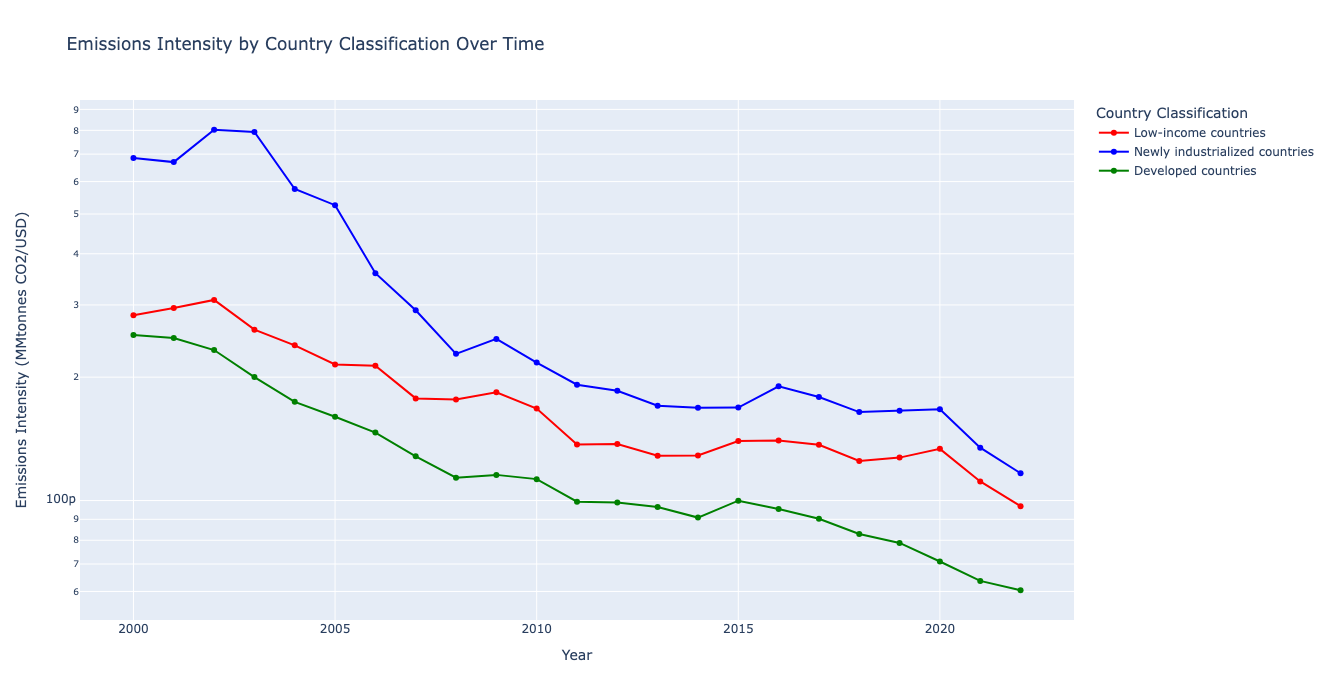

In [62]:
groups_df['Emissions Intensity'] = groups_df['Emissions'] / groups_df['Adjusted GDP']


intensity_by_classification = groups_df.groupby(['Country Classification', 'Year']).agg(
    avg_emissions_intensity=('Emissions Intensity', 'mean')
).reset_index()

low_income_df = intensity_by_classification[intensity_by_classification['Country Classification'] == 'Low-income countries']
newly_industrialized_df = intensity_by_classification[intensity_by_classification['Country Classification'] == 'Newly industrialized countries']
developed_df = intensity_by_classification[intensity_by_classification['Country Classification'] == 'Developed countries']

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=low_income_df['Year'], y=low_income_df['avg_emissions_intensity'],
    mode='lines+markers', name='Low-income countries',
    line=dict(color='red')
))

fig.add_trace(go.Scatter(
    x=newly_industrialized_df['Year'], y=newly_industrialized_df['avg_emissions_intensity'],
    mode='lines+markers', name='Newly industrialized countries',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=developed_df['Year'], y=developed_df['avg_emissions_intensity'],
    mode='lines+markers', name='Developed countries',
    line=dict(color='green')
))

fig.update_layout(
    title='Emissions Intensity by Country Classification Over Time',
    xaxis_title='Year',
    yaxis_title='Emissions Intensity (MMtonnes CO2/USD)',
    yaxis=dict(type='log'),  
    legend_title='Country Classification',
    height=700,
    width=1000
)

fig.show()

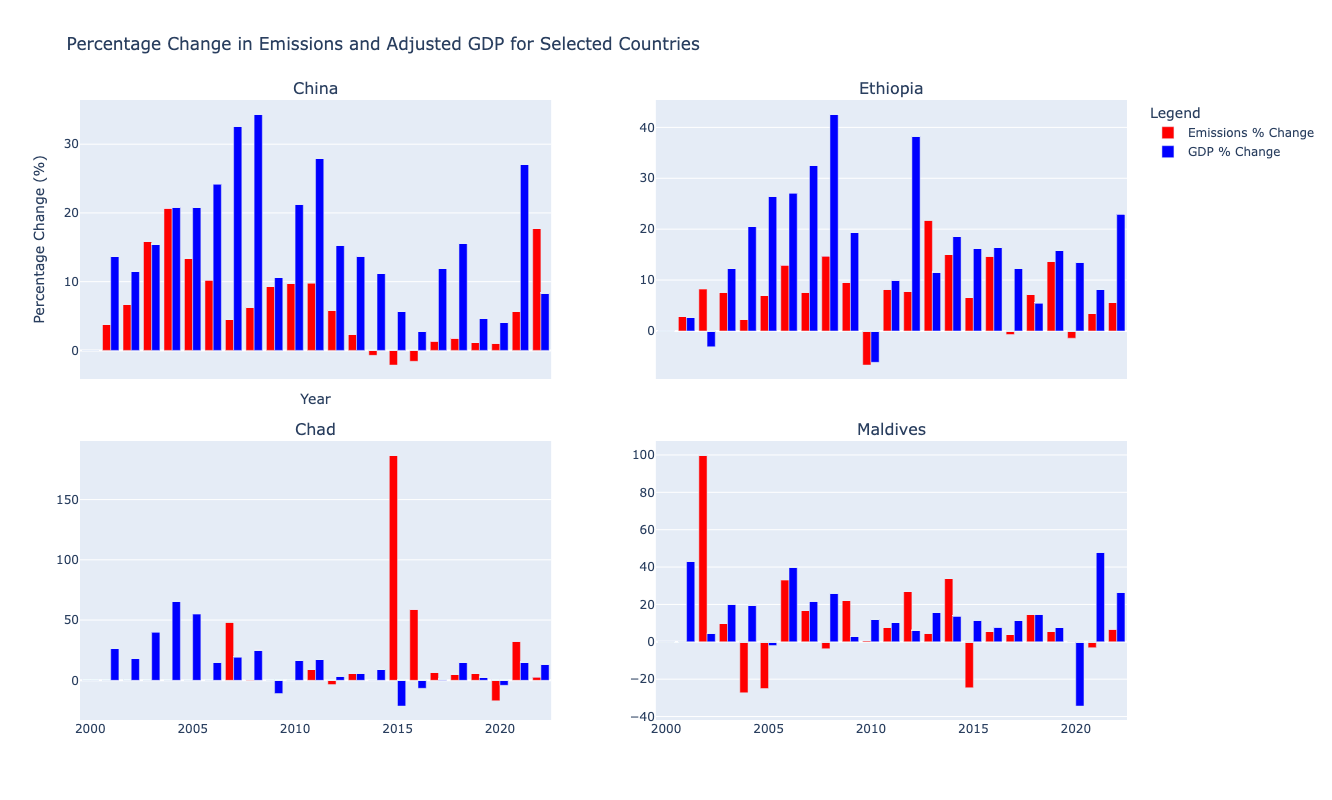

In [63]:
if 'Emissions_pct_change' not in groups_df.columns or 'Adjusted_GDP_pct_change' not in groups_df.columns:
    groups_df['GDP_to_Emissions'] = groups_df['Emissions'] / groups_df['Adjusted GDP']
    
    groups_df['Emissions_pct_change'] = groups_df.groupby('Country')['Emissions'].pct_change() * 100
    groups_df['Adjusted_GDP_pct_change'] = groups_df.groupby('Country')['Adjusted GDP'].pct_change() * 100

selected_countries = ["China", "Ethiopia", "Chad", "Maldives"]
filtered_df = groups_df[groups_df['Country'].isin(selected_countries)]

if filtered_df.empty:
    raise ValueError("Filtered DataFrame is empty. Check if the selected countries have valid data.")

fig_selected_countries = make_subplots(
    rows=2, cols=2,  
    subplot_titles=[f'{country}' for country in selected_countries],
    shared_xaxes=True, vertical_spacing=0.1, horizontal_spacing=0.1
)

def add_traces_for_selected_countries(country_list, fig):
    row_num, col_num = 1, 1
    for country in country_list:
        country_data = filtered_df[filtered_df['Country'] == country]
        
        fig.add_trace(go.Bar(
            x=country_data['Year'],
            y=country_data['Emissions_pct_change'],
            name="Emissions % Change",  
            marker=dict(color='red'),
            showlegend=(row_num == 1 and col_num == 1)  
        ), row=row_num, col=col_num)
        
        fig.add_trace(go.Bar(
            x=country_data['Year'],
            y=country_data['Adjusted_GDP_pct_change'],
            name="GDP % Change",  
            marker=dict(color='blue'),
            showlegend=(row_num == 1 and col_num == 1)  
        ), row=row_num, col=col_num)
        
        col_num += 1
        if col_num > 2:  
            col_num = 1
            row_num += 1

add_traces_for_selected_countries(selected_countries, fig_selected_countries)

fig_selected_countries.update_layout(
    height=800,
    title="Percentage Change in Emissions and Adjusted GDP for Selected Countries",
    barmode='group',  
    legend_title="Legend",
    xaxis_title="Year",
    yaxis_title="Percentage Change (%)",
    showlegend=True 
)

fig_selected_countries.show()